# Linear Regression with random search

In machine learning, instead of optimize a specific function, the actual thing we want to learn in supervised learning is a mapping that corresponds to


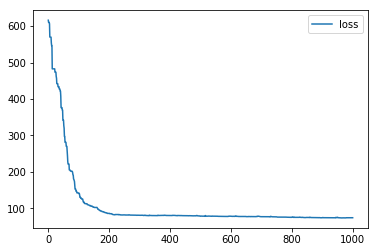

validation loss 64.39677240340932


In [200]:
import numpy as np, matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cross_validation import train_test_split
np.random.seed(42)

boston = datasets.load_boston()

X = boston['data']
y = boston['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# we change the optimizer a bit, so that it can handle a list of param vectors
# we also are no longer keeping track of 
def random_opt(X, y, layer, loss, sigma=0.00000000001, lr=100.0, num_iters=40):
    prev_val = loss(layer.run(X, layer.params()), y)
    loss_history = [prev_val]
    for _ in range(num_iters):
        # we create list of samples, here from a normal distribution
        # with zero mean and standard deviation of our learning rate
        samples = [np.random.normal(scale=sigma, size=p.shape) for p in layer.params()]
        new_params = [p + s for p, s in zip(layer.params(), samples)]
        # we measure the improvement
        improvement = prev_val - loss(layer.run(X, new_params), y)

        # apply update if it improves performance
        if improvement >= 0.0:
            for p, s, new_p in zip(layer.params(), samples, new_params):
                np.copyto(p, p + (s / sigma) * lr)
        
        prev_val = loss(layer.run(X, layer.params()), y)

        loss_history.append(prev_val)
        
    return loss_history


class LinearRegression():
    def __init__(self, size):
        self.W = np.zeros(size)
        self.b = np.array(0.0)
    
    def run(self, X, params):
        return X.dot(params[0]) + params[1]
    
    def params(self):
        return [self.W, self.b]
    
# the loss function or objective function
# this is the function which we want to minimize
def mse(y_true, y_pred):
    return np.average(np.square(y_true - y_pred))

linear_regression = LinearRegression(X.shape[1])
training_loss = random_opt(X_train, y_train, linear_regression, mse, lr=0.001, num_iters=1000)

loss_line, = plt.plot(training_loss, label='loss')
plt.legend(handles=[loss_line])
plt.show()
print("validation loss", mse(linear_regression.run(X_test, linear_regression.params()), y_test))


So far, so good. But how does it compare against for example the default scikit-learn optimizer?

In [103]:
from sklearn.linear_model import LinearRegression

linear_regression_2 = LinearRegression()

linear_regression_2.fit(X_train, y_train)

print("sklearn", mse(linear_regression_2.predict(X_test), y_test))


sklearn 20.747143360308737


Not so good it seems. While we can come close by increasing the number of iterations or try tuning the learning rate, we can try to do better using other methods.

# Adding momentum

Momentum is used in gradient-based optimization to increase learning speed by adding a exponentional moving average of the velocities.
The method is inspired by physics: a ball rolling from a hill builds up momentum, hence the name.



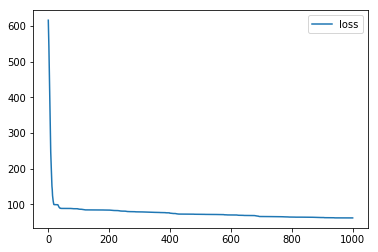

validation loss 57.25920510320722


In [161]:
def random_opt_momentum(X, y, layer, loss, lr=0.1, num_iters=40, momentum=0.9):
    prev_val = loss(layer.run(X, layer.params()), y)
    loss_history = [prev_val]
    moments = [np.zeros_like(p) for p in layer.params()]
    for _ in range(num_iters):
        samples = [np.random.normal(scale=lr, size=p.shape) for p in layer.params()]
        velocities = [s + momentum * m for  s, m in zip(samples, moments)]
        new_params = [p + v for p, v in zip(layer.params(), velocities)]
        improvement = prev_val - loss(layer.run(X, new_params), y)

        # apply update if it improves performance
        if improvement >= 0.0:
            for p, new_p, m, v in zip(layer.params(), new_params, moments, velocities):
                np.copyto(p, new_p)
                np.copyto(m, v)

        else:
            for p, s, new_p, m in zip(layer.params(), samples, new_params, moments):
                m *= momentum
        prev_val = loss(layer.run(X, layer.params()), y)

        loss_history.append(prev_val)
        
    return loss_history
  
linear_regression = LinearRegression(X.shape[1])
training_loss = random_opt_momentum(X_train, y_train, linear_regression, mse, lr=0.001, num_iters=1000)

loss_line, = plt.plot(training_loss, label='loss')
plt.legend(handles=[loss_line])
plt.show()
print("validation loss", mse(linear_regression.run(X_test, linear_regression.params()), y_test))
plt.show()


In this case, it leads to a small improvement.